# Download GitHub repository

In [1]:
%cd ~/content/
%rm -rf ~/content/ActionPrediction4CA
%rm -rf ~/content/ActionPredictionBERT
!git clone  --branch colab_exe https://github.com/jmcrav/ActionPrediction4CA.git

/home/gian/content
Clone in 'ActionPrediction4CA' in corso...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 228 (delta 109), reused 177 (delta 63), pack-reused 0
Ricezione degli oggetti: 100% (228/228), 41.19 MiB | 5.07 MiB/s, fatto.
Risoluzione dei delta: 100% (109/109), fatto.


# Elimino i file inutili al modello 
Per fare il fine tuning del modello, abbiamo bisogno solo dei dati grezzi.
Il tutor ha puntualizzato di usare SOLO lo script `simmc/mm_action_prediction/tools/extract_actions_fashion.py`, che costruisce un json con le lables associate alle azioni e agli attributi (è lo step 1 del preprocessing).
Questo credo sia necessario perchè credo che la loro implementazione sia di un livello molto più basso di quello a cui dovremo lavorare noi.
BERT è un metodo per effettuare il  pre-trained di modelli per il NLP di cui dobbiamo solo fare un fine-tuning accettabile, mentre il SIMMC deve addestrare un intero modello da zero(o comunque credo che il loro obiettivo sia cercare di creare un modello che riesca a funzionare bene col linguaggio multimodale.Non ho capito perchè non sia statu usato BERT anche da loro onestamente -  il task finale è diviso in 3 sottotask, e la prima è un problema di classificazione multi-classe per il quale BERT dovrebbe poter funzionare - forse perchè quella fornita è solo un implementazione di partenza e i concorrenti alla challenge hanno fornito le loro implementazioni dei modelli?). Praticamente tutte le operazioni che fanno loro sui dati credo servano ai loro dettagli implementativi di bassissimo livello; con BERT noi dovremo usare solo i metodi forniti dalla classe.
In pratica, partendo dai dati grezzi, dobbiamo solo darli in pasto ai metodi forniti da BERT e magari lavorare un po' per migliorare i risultati, senza che sia necessario scendere fino al livello dei transformers


**DA TENERE**
* Output dell'extract actions
*  `fashion_train_dials.json`:  per il training
*  `fashion_dev_dials.json` : per la validation
*  `fashion_teststd_dials_public.json` :per il "report dei risultati finali" (forse per darlo in pasto allo script di evaluation?) 
*   `fashion_metadata.json`, `fashion_devtest_dials.json` : necessari per il funzionamento dello script `extract_actions_fashion.py `

**DA VERIFICARE**:

 forse potrebbe convenire anche usare il vocabolario che loro si costruiscono (step 2 del preprocessing) per inizializzare il Tokenizer di Bert, come fanno loro nel data loader (in `loaders/loader_simmc.py`)
 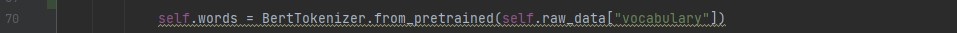

 Questo comando istanzia il tokenizer con una versione default o definita dall'utente (devo capire bene cosa significa, l'ho letto su https://huggingface.co/transformers/quickstart.html)



In [2]:
%mkdir ~/content/ActionPredictionBERT ActionPredictionBERT/input_data ActionPredictionBERT/extr_output
%cd ~/content/ActionPrediction4CA/tools
%mv extract_actions_fashion.py ~/content/ActionPredictionBERT

%cd ~/content/ActionPrediction4CA/data/simmc_fashion/
%mv fashion_train_dials.json fashion_dev_dials.json fashion_teststd_dials_public.json fashion_metadata.json fashion_devtest_dials.json ~/content/ActionPredictionBERT/input_data
# %mv fashion_train_dials_api_calls_withtranscript.json /content/ActionPredictionBERT/extr_output
 #non ci serve più tenere la cartella del progetto
%cd ~/content/
%rm -rf ./ActionPrediction4CA/

/home/gian/content/ActionPrediction4CA/tools
/home/gian/content/ActionPrediction4CA/data/simmc_fashion
/home/gian/content


#Extract_actions_fashion

In [2]:
%cd ~/content/ActionPredictionBERT/
!python extract_actions_fashion.py --json_path="input_data/fashion_train_dials.json input_data/fashion_dev_dials.json input_data/fashion_devtest_dials.json" --save_root="extr_output"  --metadata_path="fashion_metadata.json"

/home/gian/content/ActionPredictionBERT
Reading: input_data/fashion_train_dials.json
Dialogue task Id missing: 3406
Dialogue task Id missing: 3969
Dialogue task Id missing: 4847
Dialogue task Id missing: 321
Dialogue task Id missing: 3455
Dialogue task Id missing: 3414
Saving: extr_output/fashion_train_dials_api_calls.json
Reading: input_data/fashion_dev_dials.json
Dialogue task Id missing: 2117
Saving: extr_output/fashion_dev_dials_api_calls.json
Reading: input_data/fashion_devtest_dials.json
Dialogue task Id missing: 9308
Saving: extr_output/fashion_devtest_dials_api_calls.json


#Notebook originale
Script copiato dal colab di Chris McCormick e Nick Ryan
https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=nSU7yERLP_66

## 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification`.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


In [4]:
!pip install transformers

# Analisi Dataset

## train_dials

Dati grezzi da preprocessare con lo script

In [3]:
#prima parte del fashion_train_dials
import json 
import pandas as pd
with open ('input_data/fashion_train_dials.json',"r") as f:
   data= json.load(f)

result=[]
row ={}
for k in data:
  row[k] = data[k]


dialogue_data = pd.json_normalize(row['dialogue_data'])
type(dialogue_data)
# dialogue = dialogue_data["dialogue"]
# for x in dialogue.head(1):
#   display(x)
# #dialogue.head(1)
dialogue_data.head()




,dialogue,dialogue_idx,domains,dialogue_task_id,dialogue_coref_map.1426,dialogue_coref_map.1429,dialogue_coref_map.708,dialogue_coref_map.712,dialogue_coref_map.2401,dialogue_coref_map.2402,...,dialogue_coref_map.2335,dialogue_coref_map.713,dialogue_coref_map.1507,dialogue_coref_map.1509,dialogue_coref_map.949,dialogue_coref_map.1137,dialogue_coref_map.1872,dialogue_coref_map.1873,dialogue_coref_map.1753,dialogue_coref_map.834
0,[{'belief_state': [{'act': 'DA:ASK:CHECK:CLOTH...,3094,[fashion],1785.0,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[{'belief_state': [{'act': 'DA:INFORM:PREFER:C...,822,[fashion],1720.0,NaN,NaN,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[{'belief_state': [{'act': 'DA:REQUEST:GET:CLO...,7411,[fashion],2038.0,NaN,NaN,NaN,NaN,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[{'belief_state': [{'act': 'DA:INFORM:DISPREFE...,7029,[fashion],2011.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[{'belief_state': [{'act': 'DA:INFORM:DISPREFE...,1506,[fashion],1686.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#seconda parte del fashion_train_dials
task_mapping = pd.json_normalize(row['task_mapping'])
task_mapping.head()


,task_id,image_ids,focus_image,memory_images,database_images
0,2042,"[2441, 2442, 2443, 2444, 2445, 2446, 2447, 244...",2441,"[2442, 2443, 2444]","[2445, 2446, 2447, 2448, 2449, 2450]"
1,2041,"[2431, 2432, 2433, 2434, 2435, 2436, 2437, 243...",2431,"[2432, 2433, 2434]","[2435, 2436, 2437, 2438, 2439, 2440]"
2,2040,"[2421, 2422, 2423, 2424, 2425, 2426, 2427, 242...",2421,"[2422, 2423, 2424]","[2425, 2426, 2427, 2428, 2429, 2430]"
3,2039,"[2411, 2412, 2413, 2414, 2415, 2416, 2417, 241...",2411,"[2412, 2413, 2414]","[2415, 2416, 2417, 2418, 2419, 2420]"
4,2038,"[2401, 2402, 2403, 2404, 2405, 2406, 2407, 240...",2401,"[2402, 2403, 2404]","[2405, 2406, 2407, 2408, 2409, 2410]"


## dev_dials_api_calls

In [5]:
import pandas as pd
dev_dials_api = pd.read_json('extr_output/fashion_dev_dials_api_calls.json')
dev_dials_api.head()

,dialog_id,actions,focus_images
0,4146,"[{'turn_idx': 0, 'action': 'None', 'action_sup...","[1646, 1646, 1646, 1649, 1649, 1649, 1649]"
1,4260,"[{'turn_idx': 0, 'action': 'SpecifyInfo', 'act...","[2161, 2161, 2161, 2161]"
2,8022,"[{'turn_idx': 0, 'action': 'SearchDatabase', '...","[1971, 1972, 1972, 1972, 1977, 1978]"
3,4992,"[{'turn_idx': 0, 'action': 'None', 'action_sup...","[1931, 1931, 1936, 1936, 1936]"
4,5606,"[{'turn_idx': 0, 'action': 'None', 'action_sup...","[1931, 1931, 1931, 1931, 1931]"


## devtest_dials_api_calls

In [6]:
import pandas as pd
devtest_dials_api = pd.read_json('extr_output/fashion_devtest_dials_api_calls.json')
devtest_dials_api.head()

,dialog_id,actions,focus_images
0,2494,"[{'turn_idx': 0, 'action': 'SearchDatabase', '...","[1836, 1841, 1841, 1841, 1841]"
1,3731,"[{'turn_idx': 0, 'action': 'SearchDatabase', '...","[1676, 1681, 1681, 1683, 1683]"
2,8546,"[{'turn_idx': 0, 'action': 'SpecifyInfo', 'act...","[840, 840, 840, 849, 849, 843]"
3,5590,"[{'turn_idx': 0, 'action': 'SearchDatabase', '...","[1616, 1618, 1618, 1618, 1618]"
4,5452,"[{'turn_idx': 0, 'action': 'SpecifyInfo', 'act...","[2231, 2231, 2231, 2236, 2236]"


## train_dials_api_calls with transcript
Dati per il training che usiamo ( per ora semplificati)

In [7]:
import pandas as pd
import json
with open('extr_output/fashion_train_dials_api_calls.json') as f:
  dictftdac = json.load(f)
i = 0

data = []

for e in dictftdac:
  dialog_id = e['dialog_id']
  actions = e['actions']
  focus_images = e['focus_images']

  for a in actions:
    
    turn_idx = a['turn_idx']
    action = a['action']
    action_supervision = a['action_supervision']
    transcript = a['transcript']
    transcript_annotated = a['transcript_annotated']
    system_transcript = a['system_transcript']
    system_transcript_annotated = a['system_transcript_annotated']

    row = {
        "dialog_id" : dialog_id,
        'turn_idx' : turn_idx,
        'action' : action,
        'action_supervision' : action_supervision,
        'focus_images' : focus_images,
        'transcript': transcript,
        'transcript_annotated': transcript_annotated,
        'system_transcript': system_transcript,
        'system_transcript_annotated':system_transcript_annotated
    }
    if (action_supervision != None):
      if 'focus' in action_supervision:
        acsf = {'focus':action_supervision['focus']}
      else:
        acsf = {'focus':None}
      
      if 'attributes' in action_supervision:
        acsa = {'attributes':action_supervision['attributes']}
      else:
        acsa = {'attributes':None}
    else:
        acsf = {'focus':None}
        acsa = {'attributes':None}
    
      
    row.update(acsf)
    row.update(acsa)
  
    data.append(row)

# Conservo id turno e risposta sistema per provare a implementare una soluzione articolata
df_training = pd.DataFrame(data,columns=['transcript','action','attributes', 'system_transcript', 'turn_idx'])
# dialog_8701 = df[df['dialog_id'] == 8701]
# dialog_8701.head()
df_training.head()

# df['action'].value_counts()

,transcript,action,attributes,system_transcript,turn_idx
0,Is there a pattern on this one? It's hard to s...,SpecifyInfo,[pattern],"I don't have any information on the pattern, b...",0
1,That's fancy. Do you have anything in warmer c...,None,None,"I have a crew neck sweater in red, would you l...",1
2,"Yeah, that sounds good.",SearchDatabase,[],This is $187 from Downtown Stylists with a 3.6...,2
3,"Oh, I love that. Please tell me you have a small.",SpecifyInfo,[availableSizes],"It does come in small, shall I put one in your...",3
4,"Yes, please! Thank you for your help with this",AddToCart,None,My pleasure.,4


## fashion_dev_dials_api_calls
Dati per la validation 

In [8]:
import pandas as pd
import json
with open('extr_output/fashion_dev_dials_api_calls.json') as f:
  dev_dials = json.load(f)
i = 0

data = []

for e in dev_dials:
  dialog_id = e['dialog_id']
  actions = e['actions']
  focus_images = e['focus_images']

  for a in actions:
    
    turn_idx = a['turn_idx']
    action = a['action']
    action_supervision = a['action_supervision']
    transcript = a['transcript']
    transcript_annotated = a['transcript_annotated']
    system_transcript = a['system_transcript']
    system_transcript_annotated = a['system_transcript_annotated']

    row = {
        "dialog_id" : dialog_id,
        'turn_idx' : turn_idx,
        'action' : action,
        'action_supervision' : action_supervision,
        'focus_images' : focus_images,
        'transcript': transcript,
        'transcript_annotated': transcript_annotated,
        'system_transcript': system_transcript,
        'system_transcript_annotated':system_transcript_annotated
    }
    if (action_supervision != None):
      if 'focus' in action_supervision:
        acsf = {'focus':action_supervision['focus']}
      else:
        acsf = {'focus':None}
      
      if 'attributes' in action_supervision:
        acsa = {'attributes':action_supervision['attributes']}
      else:
        acsa = {'attributes':None}
    else:
        acsf = {'focus':None}
        acsa = {'attributes':None}
    
      
    row.update(acsf)
    row.update(acsa)
  
    data.append(row)

# Conservo id turno e risposta sistema per provare a implementare una soluzione articolata
df_validation = pd.DataFrame(data,columns=['transcript','action','attributes', 'system_transcript', 'turn_idx'])
df_validation.head()

,transcript,action,attributes,system_transcript,turn_idx
0,What's the price of this sweater compared to t...,None,None,This Art News Today sweater costs $143 while t...,0
1,"So the other has a v-neck, but what's the neck...",SpecifyInfo,[necklineStyle],"This one has a crew neck, Peter Pan collar.",1
2,I think I prefer that. Are there any other swe...,SearchDatabase,[],Here's another crew neck sweater you might lik...,2
3,Does it come in any other colors besides black?,SpecifyInfo,[color],"In addition to black, it also comes in purple.",3
4,Great! I'd love to buy the purple one then ple...,AddToCart,None,No problem. Is there a particular size you'd l...,4


## fashion_devtest_dials_api_calls
Dati per la valutazione delle performance del modello (test set)

In [9]:
import pandas as pd
import json
with open('extr_output/fashion_devtest_dials_api_calls.json') as f:
  test_dials = json.load(f)
i = 0

data = []

for e in test_dials:
  dialog_id = e['dialog_id']
  actions = e['actions']
  focus_images = e['focus_images']

  for a in actions:
    
    turn_idx = a['turn_idx']
    action = a['action']
    action_supervision = a['action_supervision']
    transcript = a['transcript']
    transcript_annotated = a['transcript_annotated']
    system_transcript = a['system_transcript']
    system_transcript_annotated = a['system_transcript_annotated']

    row = {
        "dialog_id" : dialog_id,
        'turn_idx' : turn_idx,
        'action' : action,
        'action_supervision' : action_supervision,
        'focus_images' : focus_images,
        'transcript': transcript,
        'transcript_annotated': transcript_annotated,
        'system_transcript': system_transcript,
        'system_transcript_annotated':system_transcript_annotated
    }
    if (action_supervision != None):
      if 'focus' in action_supervision:
        acsf = {'focus':action_supervision['focus']}
      else:
        acsf = {'focus':None}
      
      if 'attributes' in action_supervision:
        acsa = {'attributes':action_supervision['attributes']}
      else:
        acsa = {'attributes':None}
    else:
        acsf = {'focus':None}
        acsa = {'attributes':None}
    
      
    row.update(acsf)
    row.update(acsa)
  
    data.append(row)

# Conservo id turno e risposta sistema per provare a implementare una soluzione articolata
# FIXME Verificare se il test può considerare la conversazione nel suo complesso o se il
#       test deve essere fatto su una singola domanda alla volta
df_test = pd.DataFrame(data,columns=['transcript','action','attributes', 'system_transcript', 'turn_idx'])
df_test.head()


,transcript,action,attributes,system_transcript,turn_idx
0,"That looks a little too light for what I need,...",SearchDatabase,[],"This one is the highest rated, at 4.84.",0
1,Who designs it?,SpecifyInfo,[brand],This is made by Fancy Nails.,1
2,Is it available in XL?,SpecifyInfo,[availableSizes],It is available in XL.,2
3,"Awesome, go ahead and add it to my basket please.",AddToCart,None,I am adding it right now.,3
4,I appreciate your help. Thanks!,None,None,You're welcome.,4


# BERT model

##Tokenizzazione


In [10]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [11]:
#transcripts = df["transcript"]
# actions_labels = df["action"]
# attributes_labels = df["attributes"]


transcripts_tr = df_training.transcript.values
action_labels_tr = df_training.action.values
attributes_labels_tr=df_training.attributes.values


print ("TRAINING DATA:")
# Print the original sentence.
print(' Original: ', transcripts_tr[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(transcripts_tr[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(transcripts_tr[0])))

TRAINING DATA:
 Original:  Is there a pattern on this one? It's hard to see in the image.
Tokenized:  ['is', 'there', 'a', 'pattern', 'on', 'this', 'one', '?', 'it', "'", 's', 'hard', 'to', 'see', 'in', 'the', 'image', '.']
Token IDs:  [2003, 2045, 1037, 5418, 2006, 2023, 2028, 1029, 2009, 1005, 1055, 2524, 2000, 2156, 1999, 1996, 3746, 1012]


Siccome noi abbiamo due dataset separati per il training e la validation, duplichiamo il codice esistente per creare il dataset che sarà usato per la validazione (teniamo le celle separate e duplicate per rendere il codice più leggibile)

In [12]:
transcripts_vd = df_validation.transcript.values
action_labels_vd = df_validation.action.values
attributes_labels_vd=df_validation.attributes.values

print ("VALIDATION DATA:")

# Print the original sentence.
print(' Original: ', transcripts_vd[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(transcripts_vd[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(transcripts_vd[0])))

VALIDATION DATA:
 Original:  What's the price of this sweater compared to the other blue and gray one I looked at?
Tokenized:  ['what', "'", 's', 'the', 'price', 'of', 'this', 'sweater', 'compared', 'to', 'the', 'other', 'blue', 'and', 'gray', 'one', 'i', 'looked', 'at', '?']
Token IDs:  [2054, 1005, 1055, 1996, 3976, 1997, 2023, 14329, 4102, 2000, 1996, 2060, 2630, 1998, 3897, 2028, 1045, 2246, 2012, 1029]


##Required Formatting

The above code left out a few required formatting steps that we'll look at here.

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".


The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:


1.   All sentences must be padded or truncated to a single, fixed length.
2.   The maximum sentence length is 512 tokens.


Padding is done with a special [PAD] token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

In [13]:
max_len_tr = 0

# For every sentence...
for t in transcripts_tr:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(t, add_special_tokens=True)
    
    # Update the maximum sentence length.
    max_len_tr = max(max_len_tr, len(input_ids))

print('Max transcript length for training: ', max_len_tr)

Max transcript length for training:  76


In [14]:
max_len_vd = 0

# For every sentence...
for t in transcripts_vd:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(t, add_special_tokens=True)
    
    # Update the maximum sentence length.
    max_len_vd = max(max_len_vd, len(input_ids))

print('Max transcript length for validation: ', max_len_vd)

Max transcript length for validation:  54


In [15]:
if (max_len_tr >= max_len_vd):
  max_len = max_len_tr
else:
  max_len = max_len_vd

print("La massima lunghezza dei token da gestire è quindi ",max_len)

La massima lunghezza dei token da gestire è quindi  76


Now we're ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

Split the sentence into tokens.
Add the special [CLS] and [SEP] tokens.
Map the tokens to their IDs.
Pad or truncate all sentences to the same length.
Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
The first four features are in tokenizer.encode, but I'm using tokenizer.encode_plus to get the fifth item (attention masks). Documentation is here.

In [16]:
!
# Tokenize all of the sentences and map the tokens to thier word IDs.

#dobbiamo convertire le nostre lables da string a valori numerici, usiamo il metodo fornito da sklearn

#TRAINING DATASET
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
action_labels_encoded_tr = le.fit_transform(action_labels_tr)

input_ids_tr = []
attention_masks_tr = []

# For every sentence...
for t in transcripts_tr:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        t,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_tr.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_tr.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_tr = torch.cat(input_ids_tr, dim=0)
attention_masks_tr = torch.cat(attention_masks_tr, dim=0)
labels_tr = torch.tensor(action_labels_encoded_tr)

# Print sentence 0, now as a list of IDs.
print ("TRAINING : ")
print('Original: ', transcripts_tr[0])
print('Token IDs:', input_ids_tr[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/gian/anaconda3/envs/mlprj/lib/python3.7/site-packages/transformers-4.1.1-py3.8.egg/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


ImportError: Unable to convert output to PyTorch tensors format, PyTorch is not installed.

In [21]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

#dobbiamo convertire le nostre lables da string a valori numerici, usiamo il metodo fornito da sklearn

#VALIDATION DATASET
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
action_labels_encoded_vd = le.fit_transform(action_labels_vd)

input_ids_vd = []
attention_masks_vd = []

# For every sentence...
for t in transcripts_vd:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        t,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_vd.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_vd.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_vd = torch.cat(input_ids_vd, dim=0)
attention_masks_vd = torch.cat(attention_masks_vd, dim=0)
labels_vd = torch.tensor(action_labels_encoded_vd)

# Print sentence 0, now as a list of IDs.
print ("VALIDATION : ")
print('Original: ', transcripts_vd[0])
print('Token IDs:', input_ids_vd[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


VALIDATION : 
Original:  What's the price of this sweater compared to the other blue and gray one I looked at?
Token IDs: tensor([  101,  2054,  1005,  1055,  1996,  3976,  1997,  2023, 14329,  4102,
         2000,  1996,  2060,  2630,  1998,  3897,  2028,  1045,  2246,  2012,
         1029,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0])


# TRAINING

#Data Split - AP4CA
La nostra versione di split di dati per training e validation

In [22]:
from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
val_dataset = TensorDataset(input_ids_vd, attention_masks_vd, labels_vd)

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

21,196 training samples
3,513 validation samples


In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

##Train BERT model

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 

NB anche nell'articolo che sto leggendo sulla classificazione multi-label si parte da questo modello


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [24]:
from transformers import BertForSequenceClassification, AdamW, BertConfig



# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels-- 5 nel nostro caso
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)



# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [25]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [26]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [27]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [28]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [29]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [30]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.4f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    663.    Elapsed: 0:00:31.
  Batch    80  of    663.    Elapsed: 0:01:02.
  Batch   120  of    663.    Elapsed: 0:01:33.
  Batch   160  of    663.    Elapsed: 0:02:04.
  Batch   200  of    663.    Elapsed: 0:02:35.
  Batch   240  of    663.    Elapsed: 0:03:06.
  Batch   280  of    663.    Elapsed: 0:03:38.
  Batch   320  of    663.    Elapsed: 0:04:09.
  Batch   360  of    663.    Elapsed: 0:04:40.
  Batch   400  of    663.    Elapsed: 0:05:11.
  Batch   440  of    663.    Elapsed: 0:05:42.
  Batch   480  of    663.    Elapsed: 0:06:13.
  Batch   520  of    663.    Elapsed: 0:06:44.
  Batch   560  of    663.    Elapsed: 0:07:15.
  Batch   600  of    663.    Elapsed: 0:07:46.
  Batch   640  of    663.    Elapsed: 0:08:18.

  Average training loss: 0.54
  Training epcoh took: 0:08:35

Running Validation...
  Accuracy: 0.8498
  Validation Loss: 0.4162
  Validation took: 0:00:31

======== Epoch 2 / 4 ========
Training...
  Bat

Let's view the summary of the training process.

In [31]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.54,0.42,0.85,0:08:35,0:00:31
2,0.39,0.39,0.86,0:08:36,0:00:31
3,0.33,0.40,0.85,0:08:36,0:00:31
4,0.28,0.41,0.85,0:08:37,0:00:31


##Plot di training & validaion loss

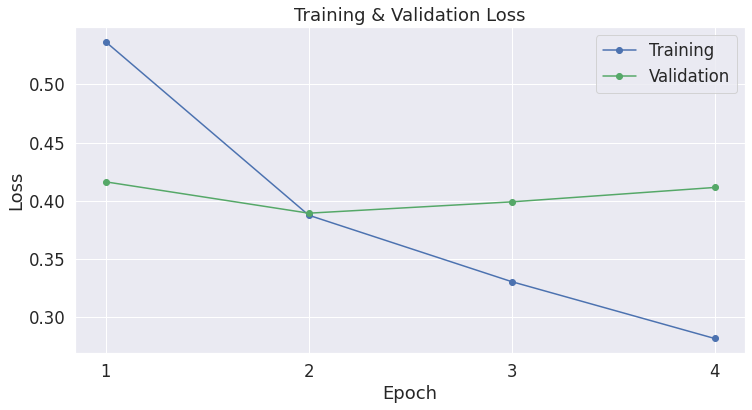

In [32]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation




We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [33]:
import pandas as pd
from sklearn import preprocessing


# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# # Create sentence and label lists
# sentences = df.sentence.values
# labels = df.label.values




transcripts_tst = df_test.transcript.values
action_labels_tst = df_test.action.values
attributes_labels_tst=df_test.attributes.values

le = preprocessing.LabelEncoder()
action_labels_encoded_tst = le.fit_transform(action_labels_tst)



# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for t in transcripts_tst:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        t,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences. -- la max_len viene calcolata sopra, quando facciamo le stesse operazioni per il training ed il validation test
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(action_labels_encoded_tst)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Print sentence 0, now as a list of IDs.
print ("TEST : ")
print('Original: ', transcripts_tst[0])
print('Token IDs:', input_ids[0])

Number of test sentences: 5,397



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


TEST : 
Original:  That looks a little too light for what I need, do you have something else with a high customer rating?
Token IDs: tensor([ 101, 2008, 3504, 1037, 2210, 2205, 2422, 2005, 2054, 1045, 2342, 1010,
        2079, 2017, 2031, 2242, 2842, 2007, 1037, 2152, 8013, 5790, 1029,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [34]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 5,397 test sentences...
    DONE.


Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [39]:
#print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

##vedere se può valere la pena fare l'analisi della nostra distribuzione di valori. La sua ovviamente non c'entra nulla con la nostra


#print('Positive samples: %d of %d (%.2f%%)' % (df_test.attributes.sum(), len(df_test.attributes), (df_test.attributes.sum() / len(df_test.attributes) * 100.0)))

In [40]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


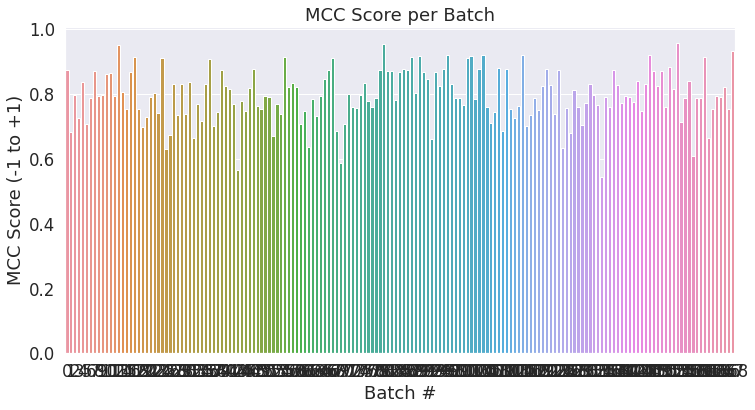

In [41]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [42]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.791


Cool! In about half an hour and without doing any hyperparameter tuning (adjusting the learning rate, epochs, batch size, ADAM properties, etc.) we are able to get a good score. 

> *Note: To maximize the score, we should remove the "validation set" (which we used to help determine how many epochs to train for) and train on the entire training set.*

The library documents the expected accuracy for this benchmark [here](https://huggingface.co/transformers/examples.html#glue) as `49.23`.

You can also look at the official leaderboard [here](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy). 

Note that (due to the small dataset size?) the accuracy can vary significantly between runs.
